In [1]:
import ee
# ee.Authenticate()
import geemap
import geemap.chart as chart
import os
geemap.ee_initialize()
# geemap.update_package()
# !pip install geemap rasterio fiona
import json
import pandas as pd
# !pip install seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ipyleaflet
import ipywidgets as widgets
import math
import datetime as dt

In [36]:
# Define a Point object
poi = ee.Geometry.Point([48.116927, 31.272270]).buffer(2000)
GF = ee.Geometry.Point([48.116927, 31.272270]).buffer(50)

# Define Map and enable drawn features exports
Map = geemap.Map(basemap="HYBRID")
Map.centerObject(poi, 13)

# Create start and end dates
start = '2021-04-01'
end = '2021-05-01'

In [37]:
# Create cloud and cirrus mask function, set to 0 to only display clear skies

# Function for cloud masking: 
# QF1 (bits 2-3, 0=confident clear, 1=probably clear)
# QF6 (bit 5, 0=good overall I3 data quality, 1=bad overall I3 data quality)
def cloudmask(image):
    qa = image.select('QF1')
    bitMask2 = 1 << 2
    bitMask3 = 1 << 3
    qf = image.select('QF6')
    bitMask5 = 1 << 5
    mask = qa.bitwiseAnd(bitMask2).eq(0).And(qa.bitwiseAnd(bitMask3).eq(0)).And(qa.bitwiseAnd(bitMask5).eq(0))
    return image.updateMask(mask)


# Function to scale data
def scale(image):
    return image.multiply(0.0001).copyProperties(image).set('system:time_start', image.get('system:time_start'))

# def addTime(image):
#     return image.addBands(image.metadata('system:index') \
#                           .divide(1000 * 60 * 60 * 24 * 365))

In [56]:
# VIIRS Surface Reflectance Daily 500m and 1km VNP09GA
VIIRS = ee.ImageCollection('NOAA/VIIRS/001/VNP09GA') \
    .filterDate(start, end) \
    .select('I3', 'M11', 'QF1', 'QF5') \
    .filterBounds(poi) \
    .map(cloudmask) \
    .map(scale) \
#     .map(lambda image: image.clip(poi)) \
#     .map(addTime) \

# Single date image
VIIRS_img = ee.Image('NOAA/VIIRS/001/VNP09GA/2021_04_21').select('I3').multiply(0.0001)

In [57]:
# # Retrieve image (collection) property info
# VIIRS.aggregate_array('system:index').getInfo()
# VIIRS_img.propertyNames().getInfo()
# VIIRS_img.getInfo()

In [54]:
# Set visualisation parameter options

vizParamsVIIRS = {
#     'bands': ['I3'],
#     'bands': ['M5', 'M4', 'M3'],
    'min': 0.4,
    'max': 0.8,
};

In [58]:
# # Add layers to Map
# Map.addLayer(VIIRS, vizParamsVIIRS, "VIIRS SR")
# Map.addLayer(VIIRS_img, vizParamsVIIRS, "VIIRS_img SR")
# Map.addLayer(Fire, {}, "MOD14A1")
# Map.addLayer(poi, {}, 'POI')
# Map.addLayer(GF, {}, 'GF')

# # Visualise map and center at area of interest
# Map.addLayerControl()
# Map.centerObject(poi, 10);
# Map

Map(bottom=27067.0, center=[31.284223532815446, 48.345898576525414], controls=(WidgetControl(options=['positio…

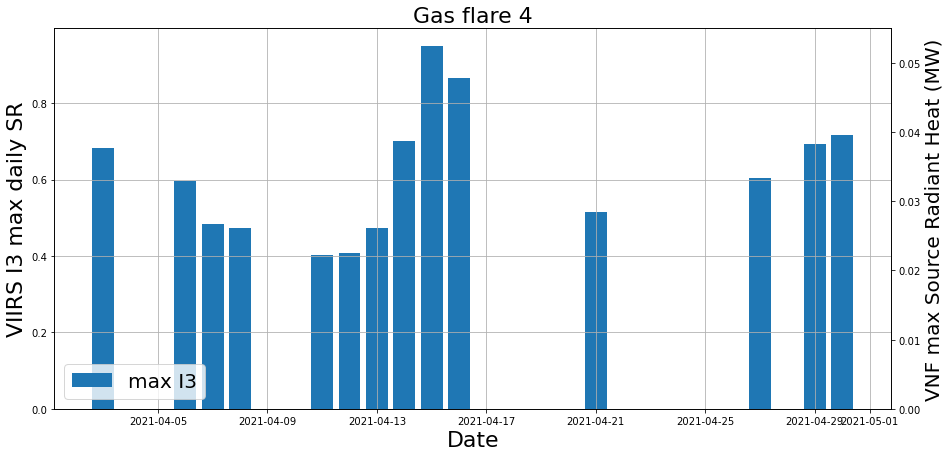

In [45]:
# Prepare time series for 1) VIIRS I3 and 2) VNF

# 1)
# Extract image values in collection (function takes single image as input and reduces data to region)
def poi_I3(img):
    max = img.reduceRegion(reducer=ee.Reducer.max(), geometry=poi, scale=500).get('I3')
    return img.set('date', img.date().format()).set('max',max)

# Apply function to all images in collection
poi_reduced_I3 = VIIRS.map(poi_I3)

# Set up function to create dataframe
def createFrame(imgs, inputList):
    # Convert image information to list (date + mean value), create pandas df and set date column to index
    img_list = imgs.reduceColumns(ee.Reducer.toList(2), inputList).values().get(0)
    df = pd.DataFrame(img_list.getInfo(), columns=inputList)
    df[inputList[0]] = pd.to_datetime(df[inputList[0]])
#     df = df.set_index('date')
    return df

# Create time series graph for POI
dfI3 = createFrame(poi_reduced_I3, ['date','max'])

# # Normalise I3 data if needed
# dfI3['NORMI3'] = (dfI3['max'] - dfI3['max'].min()) / (dfI3['max'].max() - dfI3['max'].min())


# 2)
# Read .csv from VNF reference dataset, format date, define date range
dfVNF = pd.read_csv('VNF_Gas_flares/GF4/GF4_2021_max.csv', parse_dates=['Date_Mscan'], \
                    date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

# dfVNF.rename(columns={'Date_Mscan': 'date'}, inplace=True)
# dfVNF.rename(columns={'RH': 'max'}, inplace=True)

dfVNF_filt = dfVNF.loc[(dfVNF['Date_Mscan'] >= '2021-01-01') \
                        & (dfVNF['Date_Mscan'] < '2021-12-31')]


# # Visualise plot
# 1) create pyplot figure
fig, ax = plt.subplots(figsize=(15,7))
ax2 = ax.twinx()

# 2) add df to figure
ax.bar(dfI3['date'], dfI3['max'], label='max I3')
ax2.scatter(dfVNF_filt['Date_Mscan'], dfVNF_filt['RH'], label='max VNF', marker='o', color='C1')

# 3) set figure viz
ax.set_ylabel('VIIRS I3 max daily SR', fontsize=22)
ax.set_ylim(ymin=0)
ax.set_xlabel('Date', fontsize=22)
ax.set_title('Gas flare 4', fontsize=22);
ax.grid()
ax2.set_ylim(ymin=0)
ax2.set_ylabel('VNF max Source Radiant Heat (MW)', fontsize=20)
ax.legend(loc='lower left', fontsize=20)
ax2.legend(loc='lower right', fontsize=20)
ax2.grid()

In [26]:
# Loop through df to find dates where VNF and VIIRS I3 match

# Define start and end variables
day = min(dfI3['date'])
day_end = max(dfI3['date'])

# Create starting points for both datasets and empty lists
number_total = 0
number_I3 = 0
number_VNFifI3 = 0
number_VNF = 0
list_notI3 = []
list_notVNF = []
list_notVNFifI3 = []
list_I3ifVNF = []

# Set up function to iterate through datasets
while day <= day_end:
    number_total += 1
    if day in dfI3['date'].to_list():
        number_I3 += 1
        if day in dfVNF_filt['Date_Mscan'].to_list():
            number_VNFifI3 += 1
            rowToAdd = dfI3[dfI3['date'] == day]
            list_I3ifVNF.append(rowToAdd['max'])
        else:
            list_notVNFifI3.append(day)
    else:
        list_notI3.append(day)
    if day in dfVNF_filt['Date_Mscan'].to_list():
        number_VNF += 1
    else:
        list_notVNF.append(day)
    day += dt.timedelta(days=1)


# Print information    
print("Mean I3 value on any day")
print(dfI3['max'].mean().round(decimals=2))

print("SD of I3 values on andy day")
print(dfI3['max'].std().round(decimals=2))

print("Mean I3 value on a day when VNF on")
print(np.mean(list_I3ifVNF).round(decimals=2))

print("SD of I3 values on andy day")
print(np.std(list_I3ifVNF).round(decimals=2))


print("I3 value available")
percent_I3 = str(round(100*number_I3/number_total))
print("I3: "+percent_I3+"%")

print("VNF value available")
percent_VNF = str(round(100*number_VNF/number_total))
print("VNF: "+percent_VNF+"%")

print("VNF available when I3 detected")
percent_VNFifI3 = str(round(100*number_VNFifI3/number_I3))
print("VNF: "+percent_VNFifI3+"%")

Mean I3 value on any day
0.61
SD of I3 values on andy day
0.17
Mean I3 value on a day when VNF on
0.63
SD of I3 values on andy day
0.16


In [12]:
# Loop through df to find dates where VNF is the night before a VIIRS I3 detection

# Define start and end variables
day = min(dfI3['date']) + dt.timedelta(days=1)
day_end = max(dfI3['date'])

# Create starting points for both datasets and empty lists
number_total = 0
number_I3 = 0
number_VNFbeforeI3 = 0
number_VNF = 0
list_notVNFbeforeI3 = []
list_I3ifVNFbefore = []

# Set up function to iterate through datasets
while day <= day_end:
    day_before = day - dt.timedelta(days=1)
    number_total += 1
    if day in dfI3['date'].to_list():
        number_I3 += 1
        if day_before in dfVNF_filt['Date_Mscan'].to_list():
            number_VNFbeforeI3 += 1
            rowToAdd = dfI3[dfI3['date'] == day]
            list_I3ifVNFbefore.append(rowToAdd['max'])
        else:
            list_notVNFbeforeI3.append(day)
    if day in dfVNF_filt['Date_Mscan'].to_list():
        number_VNF += 1
    day += dt.timedelta(days=1)


# Print information 
print("Mean I3 value on a day when VNF on")
print(np.mean(list_I3ifVNFbefore).round(decimals=2))

print("SD of I3 values on andy day")
print(np.std(list_I3ifVNFbefore).round(decimals=2))


print("I3 value available")
percent_I3 = str(round(100*number_I3/number_total))
print("I3: "+percent_I3+"%")

print("VNF value available")
percent_VNF = str(round(100*number_VNF/number_total))
print("VNF: "+percent_VNF+"%")

print("VNF available day before I3 detected")
percent_VNFbeforeI3 = str(round(100*number_VNFbeforeI3/number_I3))
print("VNF: "+percent_VNFbeforeI3+"%")


Mean I3 value on a day when VNF on
0.74
SD of I3 values on andy day
0.23


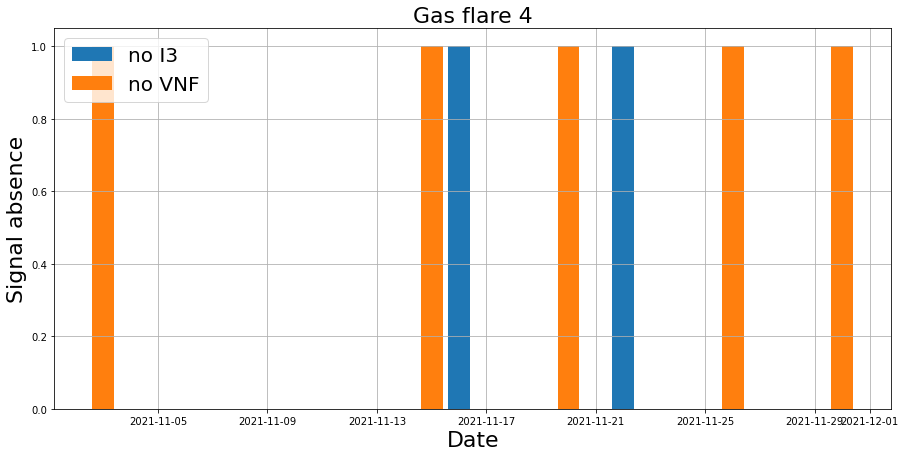

In [13]:
# Plot days on which there are no I3 or VNF detections

# Create lists for both datasets for plotting
list_notVNFbar = [1 for item in list_notVNF]
list_notI3bar = [1 for item in list_notI3]


# # Visualise plot
# 1) create pyplot figure
fig, ax = plt.subplots(figsize=(15,7))
ax2 = ax.twinx()

# 2) add df to figure
ax.bar(list_notI3, list_notI3bar, label='no I3')
ax.bar(list_notVNF, list_notVNFbar, label='no VNF', color='C1')

# 3) set figure viz
ax.set_ylabel('Signal absence', fontsize=22)
ax.set_ylim(ymin=0)
ax.set_xlabel('Date', fontsize=22)
ax.set_title('Gas flare 4', fontsize=22);
ax.legend(loc='upper left', fontsize=20)
ax.grid()
ax2.legend(loc='upper right')
ax2.set_ylim(ymin=0)
ax2.set_ylabel('VNF Source Radiant Heat (MW)', fontsize=20)

In [14]:
# Bin data month by month to see which month has the highest amount of days without any signals

# Set up function to iterate through datasets
def bin_by_month(day_list):
    df = pd.DataFrame()
    for item in day_list:
        month = item.month
        if month not in df:
            df[month] = [0]
        df[month][0] = df[month][0]+1
    df = df.T
    df.rename(columns={0: 'Absences'}, inplace=True)
    return df

# Create dataframes containing bins
df_notI3 = bin_by_month(list_notI3)
df_notVNF = bin_by_month(list_notVNF)

# Rename columns in dataframes
df_notI3.rename(columns={'Absences': 'No I3 detection'}, inplace=True)
df_notVNF.rename(columns={'Absences': 'No VNF detection'}, inplace=True)

    No I3 detection  No VNF detection
11                2                 5


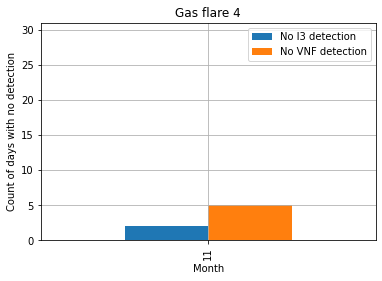

In [15]:
# Plot summarised absences of VNF and I3 per month

# Combine dataframes for plotting
frames = [df_notI3, df_notVNF]
result = pd.concat(frames, axis=1)
print(result)

# # Visualise plot
# 1) create pyplot figure
result.sort_index().plot.bar(title='Gas flare 4', xlabel='Month', ylabel='Count of days with no detection')
plt.ylim(ymin=0, ymax=31)
plt.grid()

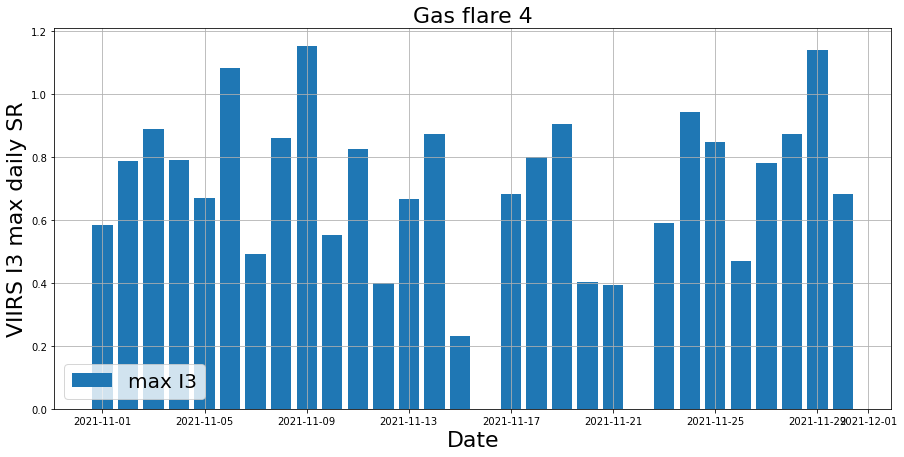

In [16]:
# # Find I3 detections in 2021 where SR values < 0.4 to investigate what values indicate unlit flares

# # dfI3_filt = dfI3.loc[(dfI3['max'] <= '0.4')]

# # 1) create pyplot figure
# fig, ax = plt.subplots(figsize=(15,7))

# # 2) add df to figure
# ax.bar(dfI3['date'], dfI3['max'], label='max I3')

# # 3) set figure viz
# ax.set_ylabel('VIIRS I3 max daily SR', fontsize=22)
# ax.set_ylim(ymin=0)
# ax.set_xlabel('Date', fontsize=22)
# ax.set_title('Gas flare 4', fontsize=22);
# ax.grid()
# ax.legend(loc='lower left', fontsize=20)